In [ ]:
# 한글 안 깨지게
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

In [ ]:
# 폰트설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')

In [ ]:
# 예측 대상과 입력 피처 정의
target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE'])

In [ ]:
# 피처 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])

In [ ]:
# 시퀀스 생성 함수
def create_multivariate_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 30
target_idx = list(feature_cols).index(target_col)

X, y = create_multivariate_sequences(scaled, target_idx, seq_len)

In [ ]:
# Train/Test 분리
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # 계산: 점수 = tanh(XW + b)
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)  # 시점별 가중치
        output = x * a  # 가중치 곱해서 출력 생성
        return K.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)  # 커스텀 Attention layer
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
from keras.callbacks import EarlyStopping
model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
model.summary()

es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[es])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │            94 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,599 (115.62 KB)

 Trainable params: 29,599 (115.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.3606e-04 - val_loss: 0.0039
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 9.2936e-04 - val_loss: 0.0021
Epoch 9/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.9343e-04 - val_loss: 9.9499e-04
Epoch 10/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 8.5015e-04 - val_loss: 0.0013
Epoch 11/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7.6942e-04 - val_loss: 0.0024
Epoch 12/30
165/1

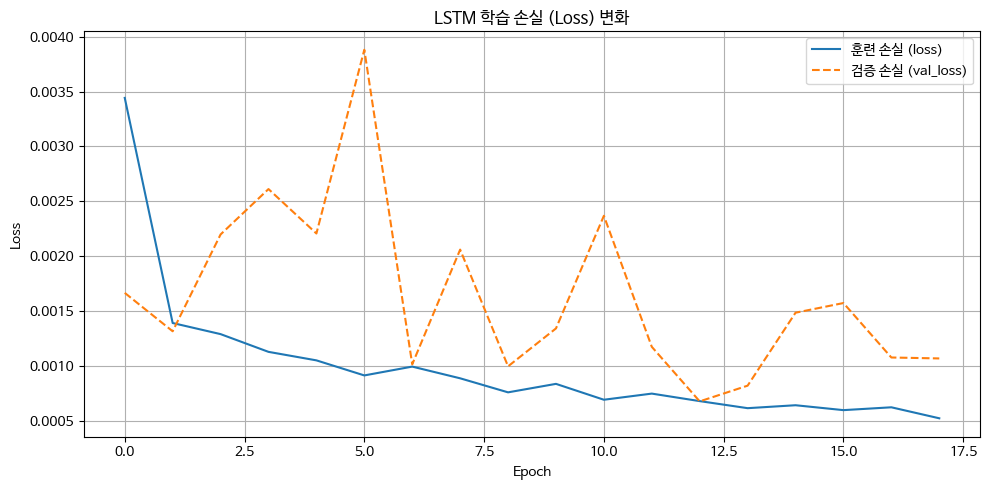

In [ ]:
# LSTM 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='훈련 손실 (loss)')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='검증 손실 (val_loss)', linestyle='--')

plt.title('LSTM 학습 손실 (Loss) 변화')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 예측
y_pred = model.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
# 역정규화: 타깃 컬럼만
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target_col]])
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

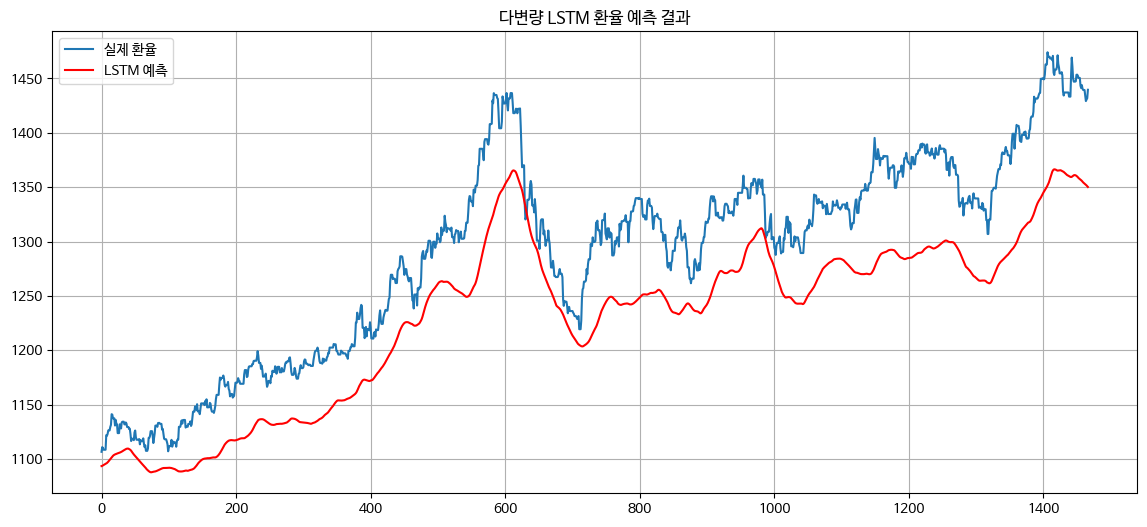

In [ ]:
# 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='실제 환율')
plt.plot(y_pred_inv, label='LSTM 예측', color='red')
plt.title('다변량 LSTM 환율 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

mse = mean_squared_error(y_test, y_pred)
print(f'MSE : {mse}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE : {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE : {mae}')

r2 = r2_score(y_test, y_pred)
print(f'R2 : {r2}')

# acc = accuracy_score(y_test, y_pred)
# print(f'Accuracy : {acc}')

MSE : 0.008783081776032951
RMSE : 0.09371809737736331
MAE : 0.08712822912112261
R2 : 0.5371511040711199


In [ ]:
n_future = 30  # 예측하고 싶은 미래 일 수
last_seq = X_test[-1]  # 마지막 입력 시퀀스 하나 선택 (shape: [seq_len, n_features])
future_preds = []

curr_seq = last_seq.copy()

for _ in range(n_future):
    # (1) 입력 shape 맞춰주기
    input_seq = curr_seq.reshape(1, seq_len, X.shape[2])

    # (2) 예측
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(pred)

    # (3) 예측값을 시퀀스에 붙여 넣기
    next_step = curr_seq[1:].copy()  # 기존 시퀀스에서 첫 번째 날 제거
    new_row = curr_seq[-1].copy()    # 마지막 날의 변수들 복사

    new_row[target_idx] = pred       # 우리가 예측한 값만 대체!
    curr_seq = np.vstack([next_step, new_row])  # 새로운 시퀀스 구성

In [ ]:
future_preds_inv = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

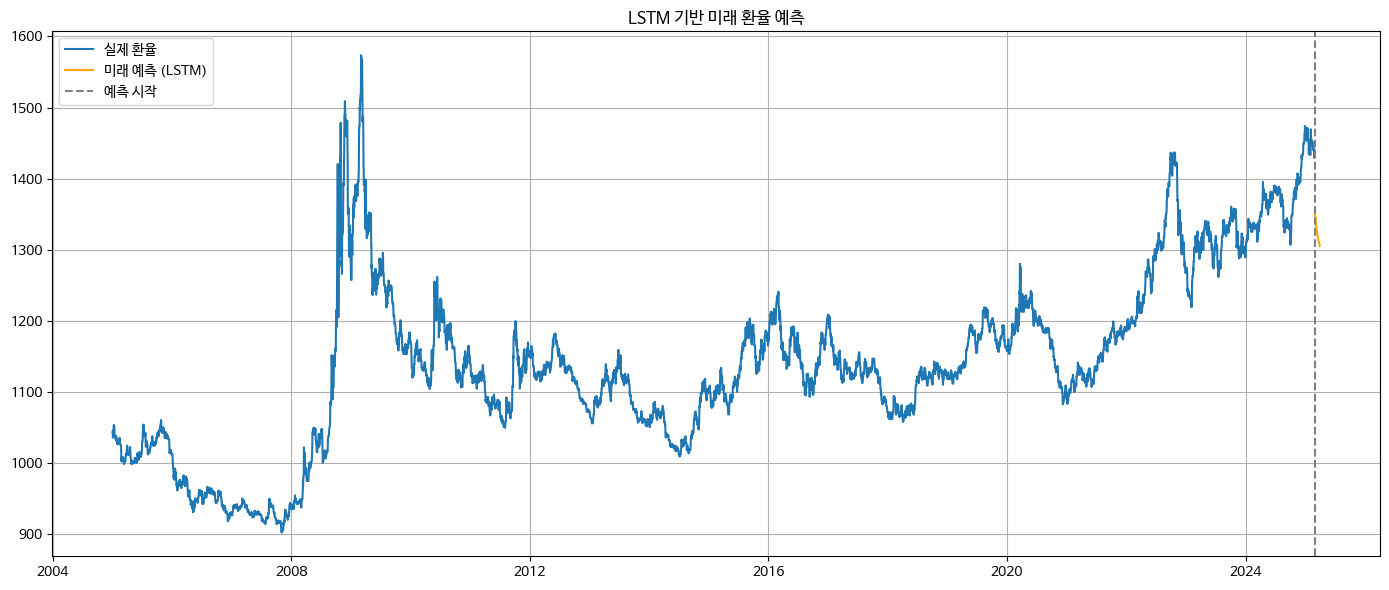

In [ ]:
# 마지막 날짜 이후부터 미래 n일 생성
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(df['DATE'], df[target_col], label='실제 환율')
plt.plot(future_dates, future_preds_inv, label='미래 예측 (LSTM)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='예측 시작')
plt.legend()
plt.title('LSTM 기반 미래 환율 예측')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
new = pd.read_csv('/content/new_0421.csv', parse_dates=['DATE'])
dollar0413 = new[new['DATE']>='2025-03-01'][['DATE','원/미국달러(매매기준율)']]
dollar0413 = dollar0413.reset_index(drop=True)

In [ ]:
real = pd.DataFrame(future_preds_inv, columns=['예측환율'])
real = pd.concat([dollar0413, real], axis=1).dropna()
real['예측차이'] = abs(real['원/미국달러(매매기준율)']-real['예측환율'])
real

,DATE,원/미국달러(매매기준율),예측환율,예측차이
0,2025-03-01,1439.6,1350.139038,89.460962
1,2025-03-02,1439.6,1348.668213,90.931787
2,2025-03-03,1439.6,1346.774658,92.825342
3,2025-03-04,1458.7,1344.595703,114.104297
4,2025-03-05,1459.6,1342.309692,117.290308
5,2025-03-06,1456.0,1339.933594,116.066406
6,2025-03-07,1441.6,1337.504639,104.095361
7,2025-03-08,1441.6,1335.055664,106.544336
8,2025-03-09,1441.6,1332.853516,108.746484
9,2025-03-10,1446.3,1330.941040,115.358960


# Rolling Forecast 시계열 교차검증

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# 데이터 로드
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')
df = df.sort_values('DATE').dropna()

target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE'])

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
target_idx = list(feature_cols).index(target_col)

def create_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 20
X, y = create_sequences(scaled, target_idx, seq_len)

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []

initial_window = int(len(X) * 0.6)
step_size = int(len(X) * 0.1)

for i, start in enumerate(range(initial_window, len(X) - step_size, step_size)):
    print(f"\n📦 Fold {i+1}")
    X_train_cv, y_train_cv = X[:start], y[:start]
    X_val_cv, y_val_cv = X[start:start + step_size], y[start:start + step_size]

    model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=32, verbose=0)

    y_pred_cv = model.predict(X_val_cv)

    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    print(f"  ✅ MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print("\n📊 전체 평균 성능")
print(f"▶ 평균 MSE : {np.mean(mse_scores):.4f}")
print(f"▶ 평균 MAE : {np.mean(mae_scores):.4f}")
print(f"▶ 평균 R²  : {np.mean(r2_scores):.4f}")


📦 Fold 1
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
  ✅ MSE: 0.0004, MAE: 0.0157, R²: 0.7445

📦 Fold 2
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
  ✅ MSE: 0.0013, MAE: 0.0289, R²: 0.6277

📦 Fold 3
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
  ✅ MSE: 0.0033, MAE: 0.0493, R²: 0.8042

📦 Fold 4
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
  ✅ MSE: 0.0038, MAE: 0.0536, R²: 0.2019

📊 전체 평균 성능
▶ 평균 MSE : 0.0022
▶ 평균 MAE : 0.0369
▶ 평균 R²  : 0.5946


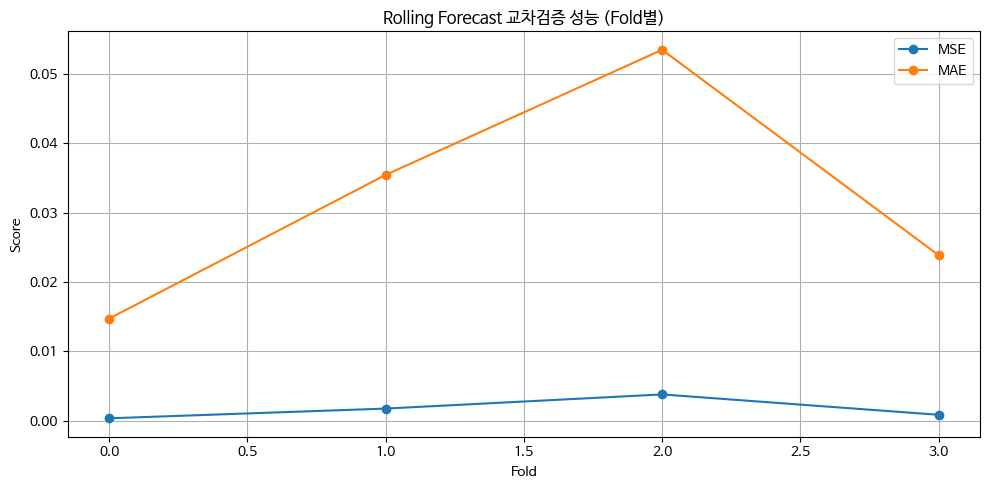

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(mse_scores, marker='o', label='MSE')
plt.plot(mae_scores, marker='o', label='MAE')
plt.title('Rolling Forecast 교차검증 성능 (Fold별)')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 좀 더 복잡한 모델

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # 점수 계산
        a = K.softmax(e, axis=1)               # 가중치 생성
        output = x * a                         # 가중치 곱해서 시점별 강조
        return K.sum(output, axis=1)           # 요약


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

def build_deep_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))

    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    x = Attention()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

In [ ]:
model = build_deep_lstm_attention_model(seq_len=30, n_features=X.shape[2])
model.summary()

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 30, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 30, 128)        │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_12 (Attention)        │ (None, 64)             │            94 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,279 (551.87 KB)

 Trainable params: 141,279 (551.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 0.0130 - val_loss: 0.0045
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - loss: 0.0019 - val_loss: 9.7944e-04
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.0014 - val_loss: 7.6486e-04
Epoch 10/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.0013 - val_loss: 6.8539e-04
Epoch 1

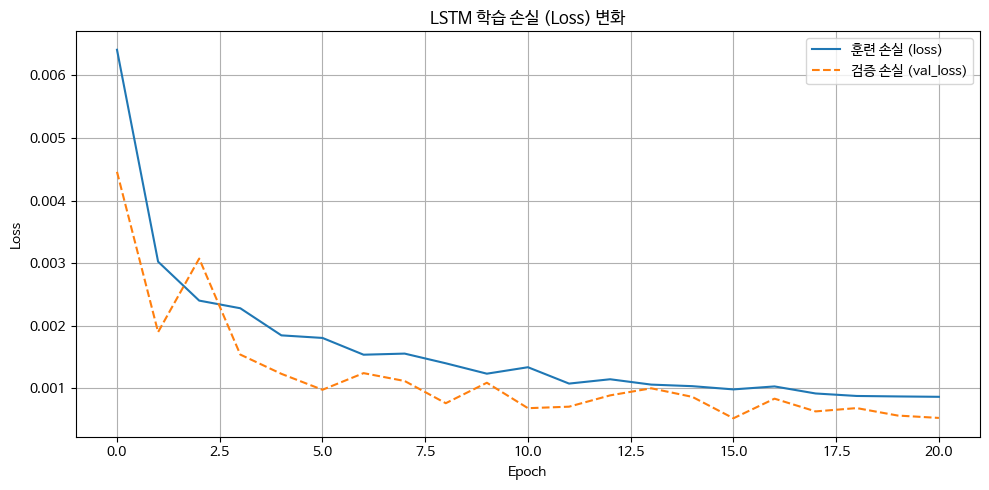

In [ ]:
# LSTM 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='훈련 손실 (loss)')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='검증 손실 (val_loss)', linestyle='--')

plt.title('LSTM 학습 손실 (Loss) 변화')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 예측
y_pred = model.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


In [ ]:
# 역정규화: 타깃 컬럼만
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target_col]])
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

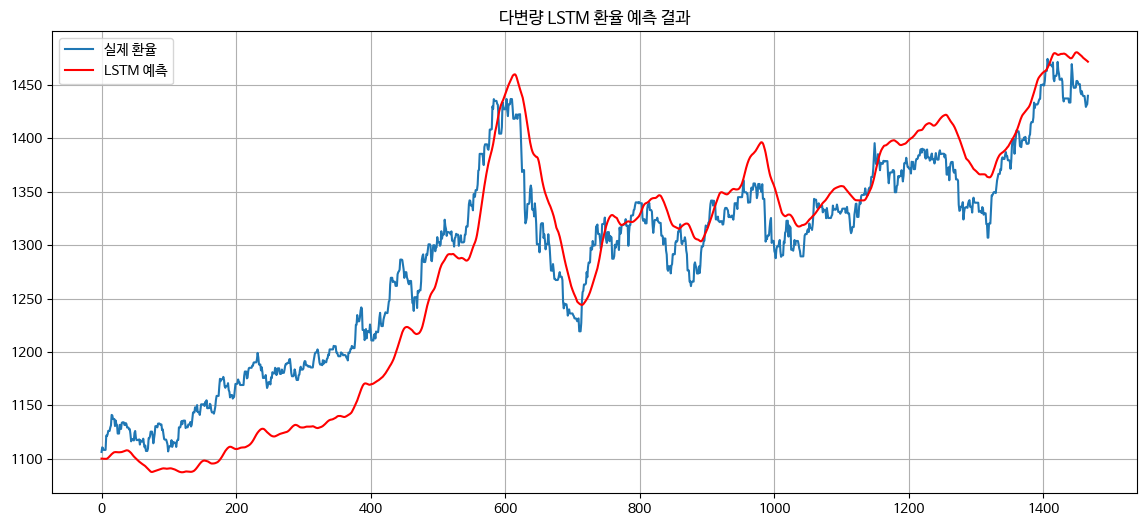

In [ ]:
# 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='실제 환율')
plt.plot(y_pred_inv, label='LSTM 예측', color='red')
plt.title('다변량 LSTM 환율 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

mse = mean_squared_error(y_test, y_pred)
print(f'MSE : {mse}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE : {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE : {mae}')

r2 = r2_score(y_test, y_pred)
print(f'R2 : {r2}')

# acc = accuracy_score(y_test, y_pred)
# print(f'Accuracy : {acc}')

MSE : 0.00338858613343842
RMSE : 0.05821156357149686
MAE : 0.05044936618032412
R2 : 0.8214290393035273


In [ ]:
n_future = 30  # 예측하고 싶은 미래 일 수
last_seq = X_test[-1]  # 마지막 입력 시퀀스 하나 선택 (shape: [seq_len, n_features])
future_preds = []

curr_seq = last_seq.copy()

for _ in range(n_future):
    # (1) 입력 shape 맞춰주기
    input_seq = curr_seq.reshape(1, 30, X.shape[2])

    # (2) 예측
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(pred)

    # (3) 예측값을 시퀀스에 붙여 넣기
    next_step = curr_seq[1:].copy()  # 기존 시퀀스에서 첫 번째 날 제거
    new_row = curr_seq[-1].copy()    # 마지막 날의 변수들 복사

    new_row[target_idx] = pred       # 우리가 예측한 값만 대체!
    curr_seq = np.vstack([next_step, new_row])  # 새로운 시퀀스 구성

In [ ]:
future_preds_inv = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

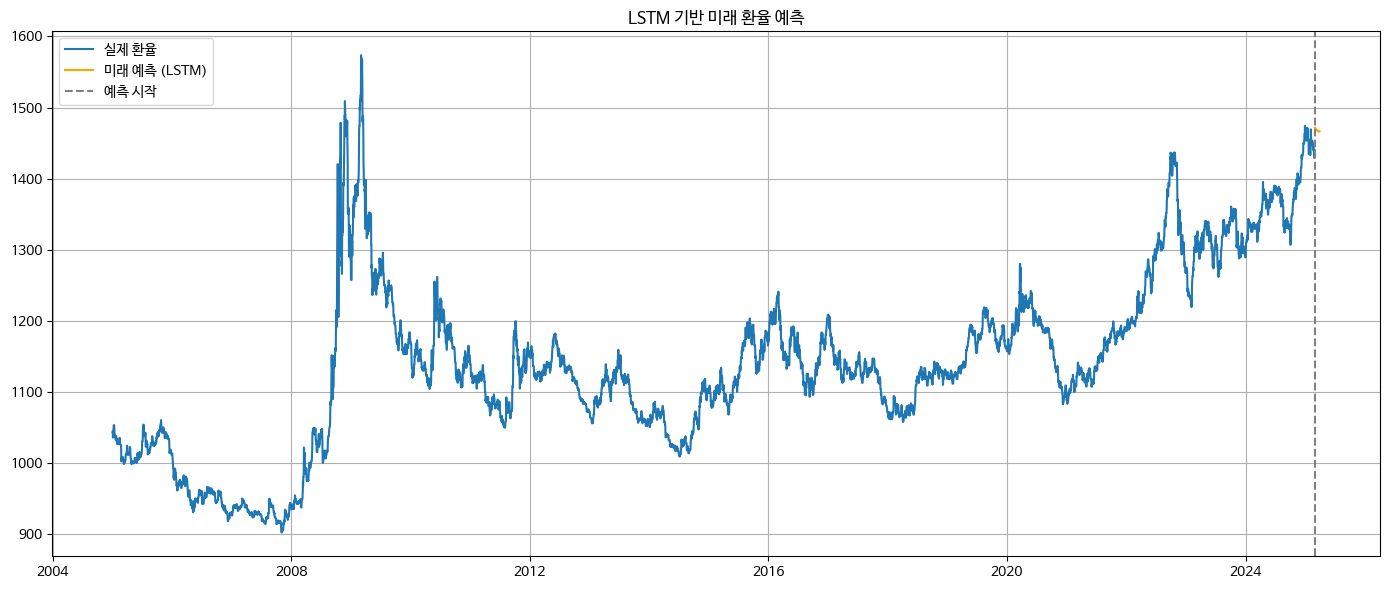

In [ ]:
# 마지막 날짜 이후부터 미래 n일 생성
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(df['DATE'], df[target_col], label='실제 환율')
plt.plot(future_dates, future_preds_inv, label='미래 예측 (LSTM)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='예측 시작')
plt.legend()
plt.title('LSTM 기반 미래 환율 예측')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
real = pd.DataFrame(future_preds_inv, columns=['예측환율'])
real = pd.concat([dollar0413, real], axis=1).dropna()
real['예측차이'] = abs(real['원/미국달러(매매기준율)']-real['예측환율'])
real

,DATE,원/미국달러(매매기준율),예측환율,예측차이
0,2025-03-01,1439.6,1471.505737,31.905737
1,2025-03-02,1439.6,1470.933228,31.333228
2,2025-03-03,1439.6,1470.432129,30.832129
3,2025-03-04,1458.7,1470.109131,11.409131
4,2025-03-05,1459.6,1469.888184,10.288184
5,2025-03-06,1456.0,1469.694702,13.694702
6,2025-03-07,1441.6,1469.199707,27.599707
7,2025-03-08,1441.6,1468.616577,27.016577
8,2025-03-09,1441.6,1468.216187,26.616187
9,2025-03-10,1446.3,1468.089478,21.789478


## 시계열 교차 검증

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [ ]:
def build_deep_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))

    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    x = Attention()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

In [ ]:
# 데이터 로드
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')
df = df.sort_values('DATE').dropna()

target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE'])

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
target_idx = list(feature_cols).index(target_col)

def create_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(scaled, target_idx, seq_len)

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []

initial_window = int(len(X) * 0.6)
step_size = int(len(X) * 0.1)

for i, start in enumerate(range(initial_window, len(X) - step_size, step_size)):
    print(f"\n📦 Fold {i+1}")
    X_train_cv, y_train_cv = X[:start], y[:start]
    X_val_cv, y_val_cv = X[start:start + step_size], y[start:start + step_size]

    model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=32, verbose=0)

    y_pred_cv = model.predict(X_val_cv)

    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    print(f"  ✅ MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print("\n📊 전체 평균 성능")
print(f"▶ 평균 MSE : {np.mean(mse_scores):.4f}")
print(f"▶ 평균 MAE : {np.mean(mae_scores):.4f}")
print(f"▶ 평균 R²  : {np.mean(r2_scores):.4f}")


📦 Fold 1
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
  ✅ MSE: 0.0018, MAE: 0.0378, R²: -0.2366

📦 Fold 2
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
  ✅ MSE: 0.0019, MAE: 0.0378, R²: 0.4581

📦 Fold 3
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
  ✅ MSE: 0.0017, MAE: 0.0356, R²: 0.8993

📦 Fold 4
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
  ✅ MSE: 0.0027, MAE: 0.0415, R²: 0.4233

📊 전체 평균 성능
▶ 평균 MSE : 0.0020
▶ 평균 MAE : 0.0382
▶ 평균 R²  : 0.3860
